In [6]:
%pylab inline
import pandas as pd
from scipy.linalg import sqrtm, inv, eig
from collections import OrderedDict
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
def orthogonalize_U(A, max_iter=5000):
    '''
    Find closest orthogonal matrix to U iteratively.
    '''
    # 
    

    TOLERANCE = np.max((1, np.max(A.shape) * np.linalg.svd(A.T, False, False)[0])) * np.finfo(A.dtype).eps# TODO
    reldiff     = lambda a,b: 2*abs(a-b) / (abs(a)+abs(b))
    convergence = lambda rho, prev_rho: reldiff(rho, prev_rho) <= TOLERANCE

    A_b  = A.conj()
    d = np.sqrt(np.sum(A*A_b,axis=1))

    rhos = np.zeros(max_iter)

    for i in range(max_iter):
        scA = A.T * d

        u, s, vh = np.linalg.svd(scA, False)

        V = np.dot(u, vh)

        # TODO check is rank is full
        d = np.sum(A_b*V.T, axis=1)

        L = (V * d).T
        E = A-L
        rhos[i] = np.sqrt(np.sum(E*E.conj()))
        if i > 0 and convergence(rhos[i], rhos[i - 1]):
            break
    return L   
def sym(w):
    return w.dot(inv(sqrtm(w.T.dot(w))))
def ho_SVD(list_of_X):
    """ Perform higher order SVD
    
    list_of_X: list
               [X_1, X_2, X_3, ..., X_n] size (n x m)
    
    """
    # Step 1
    # A_i = X_i^T X_i
    # A_inv = moore_penrose_inv(A_i)
    A = []
    N = len(list_of_X)
    A_inv = []
    for X in list_of_X:
        A_i = np.dot(X.T, X)
        A.append(A_i)
        A_inv.append(np.linalg.inv((A_i)))
    # Step 2
    # W = 1/N(N-1) * sum_{i=1}^jn sum_{j>i}^N A_i moore_penrose_inv(A_j) + A_j moore_penrose_inv(A_i)
    W = 0
    
    for i in range(N):
        for j in range(i+1, N):
            W = W + (np.dot(A[i], A_inv[j]) + np.dot(A[j], A_inv[i]))
    W =  W/(N*(N-1))
    
    # Step 3
    # Eigen decomposition of W?
    # WV = V\Lambda
    # V= (v_1, v_2, ..., v_n)
    # ||v||_k =1, but V is not necesarrily orthonormal
    # But we don't
    
    eigen_values, V = eig(W)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    V = V[:,idx]
    
    
    # Step 4
    # solve for  VB_i = X_i^T
     #Calculate the Bi matrices
   
    B = []
    U = []
    U_ortho_s = []
    U_ortho_p = []
    sigmas = []
    for X in list_of_X:
        #B_i = spams.omp( np.asfortranarray(X.T), V, lambda1=0, numThreads = 24)]
        # VB.T = X.T
        B_i = np.dot(np.linalg.inv(V), X.T).T
        B.append(B_i)
        sigma_i  = np.linalg.norm(B_i, axis=0) #einsum_col_norm(B)
        U_i = B_i/sigma_i 
        sigmas.append(sigma_i)
        U.append(U_i)
        
        UTU = np.dot(U_i.T, U_i)
        #u_ortho = np.dot(U_i, np.power(np.linalg.inv(UTU), 0.5))
        u_ortho = np.dot(U_i, np.linalg.inv(UTU))
        U_ortho_p.append(u_ortho)
        
        U_ortho_s.append(sym(U_i))
        
    return U, sigmas, V, U_ortho_p, U_ortho_s

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/faiss/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['eig', 'inv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [36]:
factors = pd.read_table('../../andrews_work/factors.txt', sep= ' ')
outlier = 'SRR7134937'

factors = factors[factors.srr!=outlier]
factors.head()

,srr,species,tissue,sex
0,SRR7134925,human,brain,male
1,SRR7134926,human,brain,male
2,SRR7134927,human,brain,male
3,SRR7134928,human,brain,male
4,SRR7134929,human,heart,male


In [37]:
n_tissues = len(factors['tissue'].unique())
species = factors['species'].unique()
n_species = len(species)
samples = factors['srr']
n_samples = len(samples)
tissues = factors['tissue'].unique()

In [38]:
raw_data = OrderedDict()#pd.DataFrame()
log2_data = OrderedDict()
log2_data_matrix  = OrderedDict()
for species in factors['species'].unique():
    df = pd.read_table('../../andrews_work/{}.tsv'.format(species), index_col=0)
    if outlier in df.columns:
        df = df.drop(columns=outlier)
    raw_data[species] = df
    log2_data[species] = np.log2(df+1)
    log2_data_matrix[species] = np.log2(df+1).values
    
mean_data_df = OrderedDict()
mean_data_matrix = OrderedDict()
for species in factors['species'].unique():
    raw = log2_data[species]
    tissue_df = pd.DataFrame()
    for tissue in tissues:
        tissue_samples = factors[(factors.species == species) & (factors.tissue == tissue) ].srr
        subset = raw.loc[:, tissue_samples]
        subset_mean = subset.mean(axis=1)
        subset_mean_df = subset_mean.to_frame().rename(columns={0: tissue})
        tissue_df = tissue_df.join(subset_mean_df, how='outer')
        
    mean_data_df[species]= tissue_df
    mean_data_matrix[species] = tissue_df.values

In [39]:
mean_data_df['human'].head()

,brain,heart,kidney,liver
ENSG00000000003,7.904239,7.773010,11.462971,9.553614
ENSG00000000005,2.453445,2.668106,4.229716,1.660964
ENSG00000000419,8.831058,8.988337,9.231123,8.344828
ENSG00000000457,7.971010,7.399995,9.055568,7.412281
ENSG00000000460,5.954908,5.076589,6.857123,5.227664


In [40]:
mean_data_matrix['human'].shape

(58676, 4)

In [41]:
U, sigmas, V, U_ortho_p, U_ortho_s = ho_SVD(mean_data_matrix.values())

In [42]:
MARKERS = ['o',  'x', '^', '*','>', '<', 's',  'H',  '8', 'p', 'h',  'D', 'd', 'P']

markers_dict  = {'human': 'o', 'macaque': '^', 'marmoset': '+', 'mouse':'x', 'rat': 's', 'rabbit': '*'}
colors_dict = {'brain': 'black', 'heart': 'red', 'kidney': 'green', 'liver':'blue'}


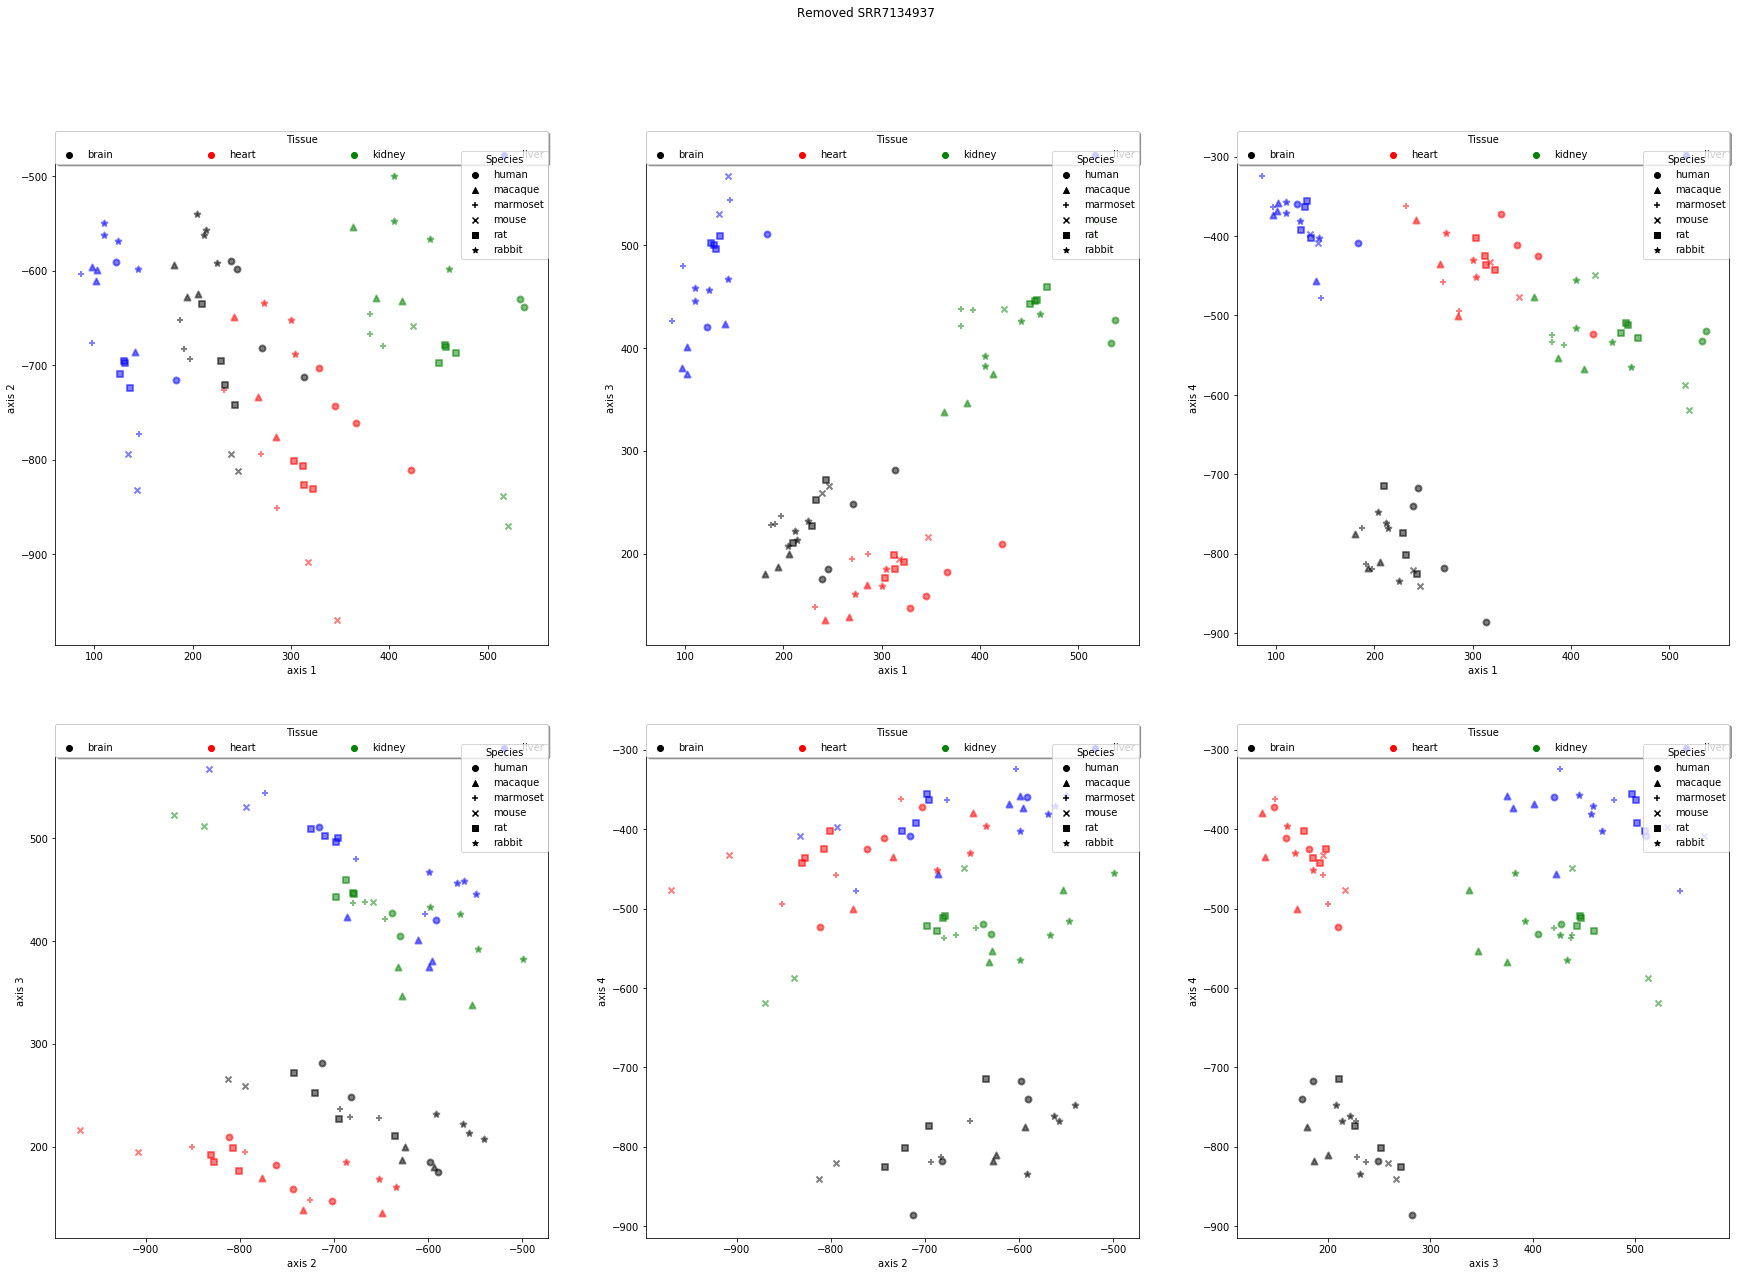

In [46]:
axes = [0, 1]

def plot_stuff(pair_of_axes, ax):
    for index, species in enumerate(mean_data_matrix.keys()):
        log2_matrix = log2_data_matrix[species]
        samples = np.array(log2_data[species].columns)
        #sample_tissues = np.array([factors[factors.srr==sample].tissue for sample in samples])
        sample_tissues = np.array([str(factors[factors.srr==sample].tissue.values[0]) for sample in samples])

        transform = U_ortho_p[index]
        projection = np.dot(log2_matrix.T, transform)
        projection_2D = projection[:, pair_of_axes]
        for tissue in tissues:
            idx = (sample_tissues==tissue)
            ax.scatter(projection_2D[idx, 0], 
                       projection_2D[idx, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species],
                       alpha=0.5,
                       lw=2)

    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        annotations.append(tissue)
        scatter_points.append(p)


    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(species)
        scatter_points.append(p)

    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    ax.set_xlabel('axis {}'.format(pair_of_axes[0]+1))
    ax.set_ylabel('axis {}'.format(pair_of_axes[1]+1))
    
fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(231)
plot_stuff([0,1], ax)
ax = plt.subplot(232)
plot_stuff([0,2], ax)
ax = plt.subplot(233)
plot_stuff([0,3], ax)
ax = plt.subplot(234)
plot_stuff([1,2], ax)
ax = plt.subplot(235)
plot_stuff([1,3], ax)
ax = plt.subplot(236)
plot_stuff([2,3], ax)


fig.suptitle('Removed {}'.format(outlier))

fig.savefig('all_species_U_ortho_p_rm_outlier_{}.pdf'.format(outlier), bbox_inches='tight')





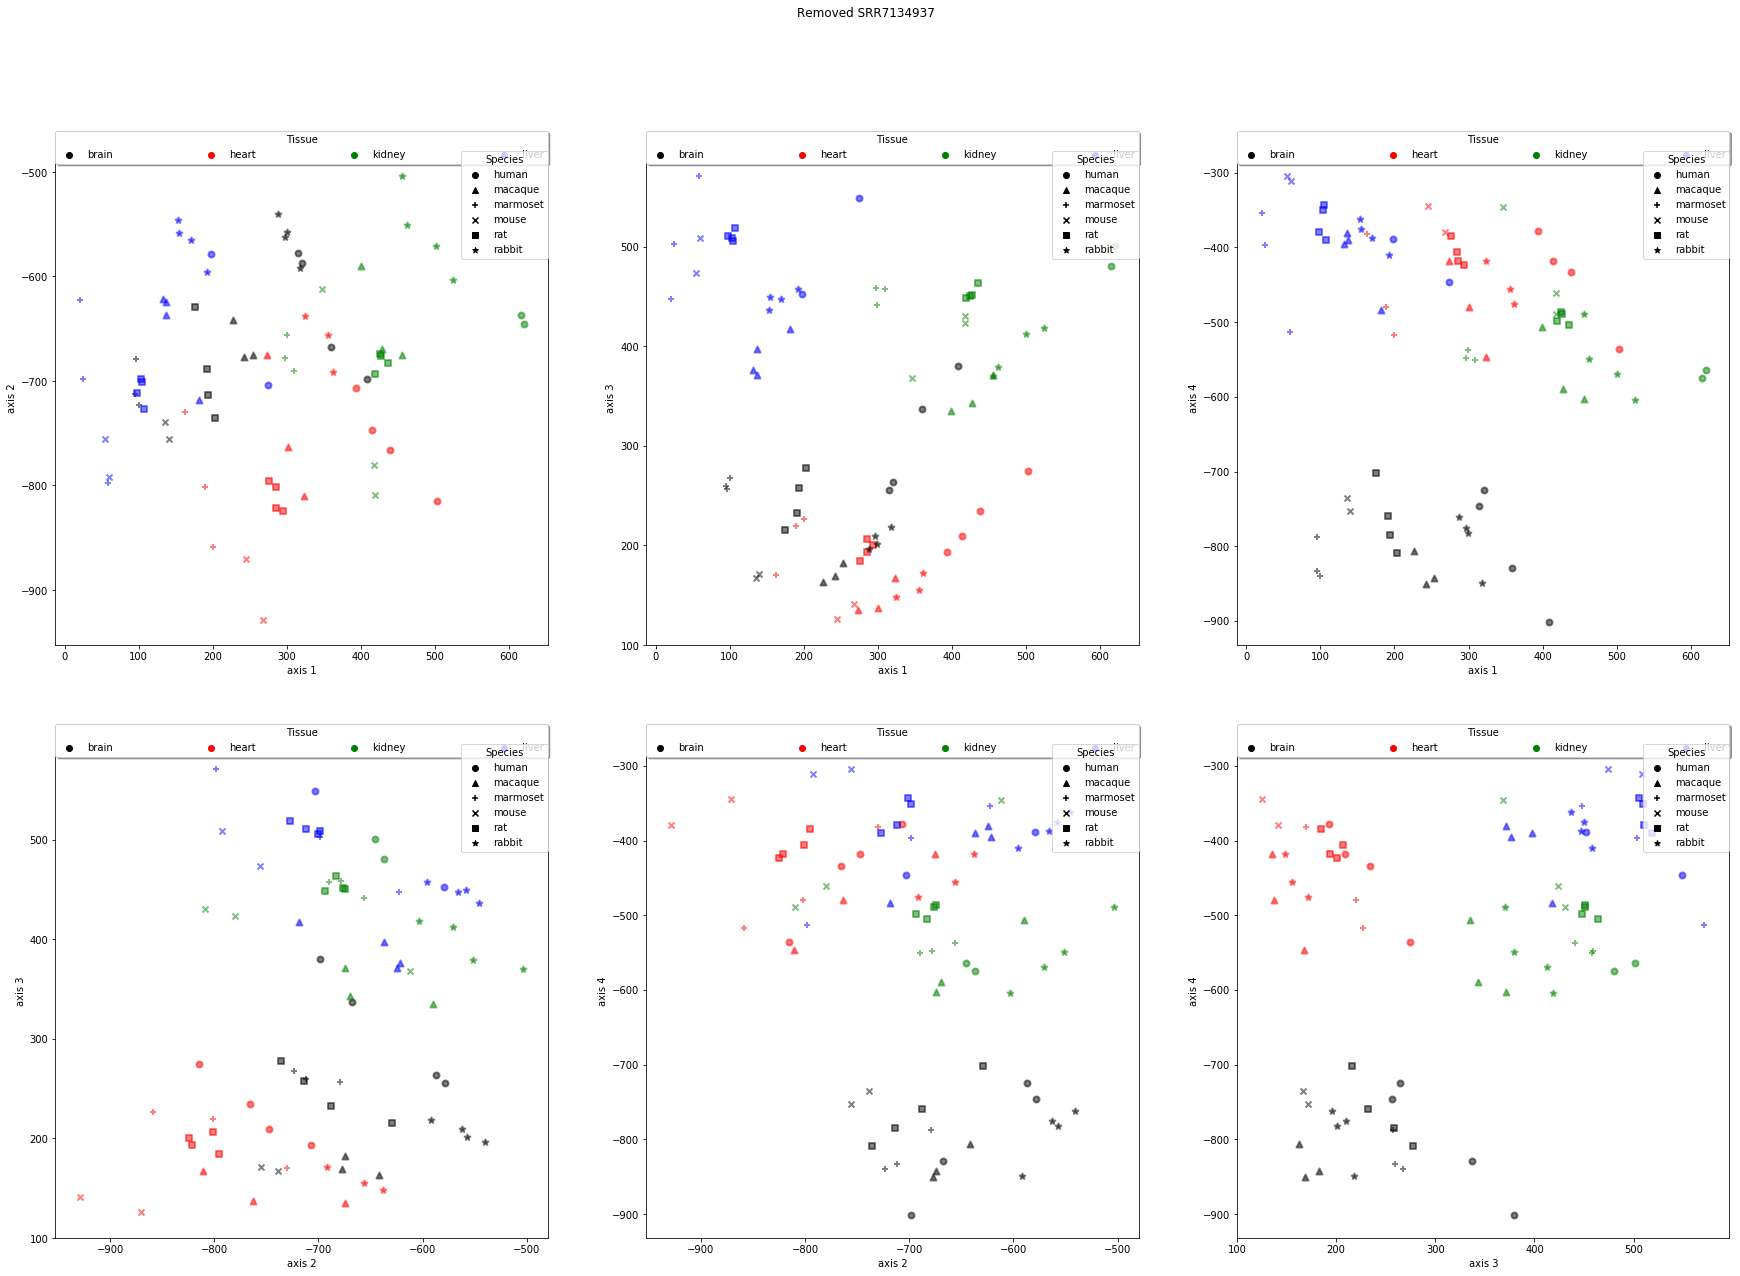

In [47]:
axes = [0, 1]

def plot_stuff(pair_of_axes, ax):
    for index, species in enumerate(mean_data_matrix.keys()):
        log2_matrix = log2_data_matrix[species]
        samples = np.array(log2_data[species].columns)
        #sample_tissues = np.array([factors[factors.srr==sample].tissue for sample in samples])
        sample_tissues = np.array([str(factors[factors.srr==sample].tissue.values[0]) for sample in samples])

        transform = U_ortho_s[index]
        projection = np.dot(log2_matrix.T, transform)
        projection_2D = projection[:, pair_of_axes]
        for tissue in tissues:
            idx = (sample_tissues==tissue)
            ax.scatter(projection_2D[idx, 0], 
                       projection_2D[idx, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species],
                       alpha=0.5,
                       lw=2)

    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        annotations.append(tissue)
        scatter_points.append(p)


    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(species)
        scatter_points.append(p)

    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    ax.set_xlabel('axis {}'.format(pair_of_axes[0]+1))
    ax.set_ylabel('axis {}'.format(pair_of_axes[1]+1))
    
fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(231)
plot_stuff([0,1], ax)
ax = plt.subplot(232)
plot_stuff([0,2], ax)
ax = plt.subplot(233)
plot_stuff([0,3], ax)
ax = plt.subplot(234)
plot_stuff([1,2], ax)
ax = plt.subplot(235)
plot_stuff([1,3], ax)
ax = plt.subplot(236)
plot_stuff([2,3], ax)
fig.suptitle('Removed {}'.format(outlier))

fig.savefig('all_species_U_ortho_s_rm_outlier_{}.pdf'.format(outlier), bbox_inches='tight')



